## Daten zusammenfügen und erster Blick auf die Daten

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import holidays
import numpy as np
from sklearn.model_selection import train_test_split

In [16]:
# Datensatz einlesen
umsatzdaten = pd.read_csv('0_DataPreparation/umsatzdaten_gekuerzt.csv')
wetter = pd.read_csv('0_DataPreparation/wetter.csv')
kiwo = pd.read_csv('0_DataPreparation/kiwo.csv')

# Daten zusammenführen als outer join
merged_data = pd.merge(umsatzdaten, wetter, on='Datum', how='outer')
merged_data = pd.merge(merged_data, kiwo, on='Datum', how='outer')

# Umsatzdaten anzeigen
print(merged_data.head())
print(merged_data.info())
print(merged_data.describe())

# Wie viele NaNs gibt es?
print(merged_data.isnull().sum())

        Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0  2012-01-01          NaN     NaN         8.0      9.8250   
1  2012-01-02          NaN     NaN         7.0      7.4375   
2  2012-01-03          NaN     NaN         8.0      5.5375   
3  2012-01-04          NaN     NaN         4.0      5.6875   
4  2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  
0                 14.0        58.0          NaN  
1                 12.0         NaN          NaN  
2                 18.0        63.0          NaN  
3                 19.0        80.0          NaN  
4                 23.0        80.0          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10119 entries, 0 to 10118
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                10119 non-null  object 
 1   Warengruppe          9334 non-null   float64
 2   Umsatz        

## Feiertage hinzufügen

In [17]:
# Liste der Feiertage für Deutschland
de_holidays = holidays.Germany()

# Datumsbereich
start_date = '2012-01-01'
end_date = '2019-08-01'

# Liste aller Tage im Datumsbereich
date_range = pd.date_range(start=start_date, end=end_date)

# Liste zur Speicherung des Feiertagsstatus
holiday_status = []

# Überprüfung jedes Datums auf Feiertag
for date in date_range:
    if date in de_holidays:
        holiday_status.append(1)  # Feiertag
    else:
        holiday_status.append(0)  # normaler Tag

# Erstellen eines DataFrame mit Datum und Feiertagsstatus
holiday_df = pd.DataFrame({'Datum': date_range, 'Feiertag': holiday_status})

# Anzeigen der ersten Zeilen des DataFrame
print(holiday_df.head())

# Datum in umsatzdaten in datetime umwandeln
merged_data['Datum'] = pd.to_datetime(merged_data['Datum'])

# holiday_df mit umsatzdaten zusammenführen
merged_data = pd.merge(merged_data, holiday_df, on='Datum', how='outer')

# Anzeigen der ersten Zeilen des DataFrame
print(merged_data)

       Datum  Feiertag
0 2012-01-01         1
1 2012-01-02         0
2 2012-01-03         0
3 2012-01-04         0
4 2012-01-05         0
           Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0     2012-01-01          NaN     NaN         8.0      9.8250   
1     2012-01-02          NaN     NaN         7.0      7.4375   
2     2012-01-03          NaN     NaN         8.0      5.5375   
3     2012-01-04          NaN     NaN         4.0      5.6875   
4     2012-01-05          NaN     NaN         6.0      5.3000   
...          ...          ...     ...         ...         ...   
10280 2019-07-28          NaN     NaN         3.0     23.3500   
10281 2019-07-29          NaN     NaN         6.0     25.2500   
10282 2019-07-30          NaN     NaN         7.0     20.7375   
10283 2019-07-31          NaN     NaN         6.0     20.4500   
10284 2019-08-01          NaN     NaN         5.0     21.0625   

       Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  
0                

## Variablen Wochenende und Wochentag hinzufügen

In [18]:
# Variable Wochenende hinzufügen
merged_data['Datum'] = pd.to_datetime(merged_data['Datum'])
merged_data['Wochenende'] = merged_data['Datum'].dt.dayofweek >= 5

# Variable Wochentag hinzufügen
merged_data['Wochentag'] = merged_data['Datum'].dt.dayofweek


## Variable Temperaturabweichung vom Monatsmittel hinzufügen 

In [19]:
# Variable für Temperaturabweichung um Mittelwert der Temperatur für jeden Monat berechnen
# Um die Monate zu extrahieren
merged_data['Monat'] = merged_data['Datum'].dt.month

# Mittelwerte der Temperatur für jeden Monat berechnen
monatsmittel_temp = merged_data.groupby('Monat')['Temperatur'].transform('mean')

# Um die Temperaturabweichung zu berechnen
merged_data['Temp_abw'] = (merged_data['Temperatur'] - monatsmittel_temp).abs() > 5

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())

# Wie oft True für Temp_abw
print(merged_data['Temp_abw'].value_counts())


       Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  \
0                 14.0        58.0          NaN         1        True   
1                 12.0         NaN          NaN         0       False   
2                 18.0        63.0          NaN         0       False   
3                 19.0        80.0          NaN         0       False   
4                 23.0        80.0          NaN         0       False   

   Wochentag  Monat  Temp_abw  
0          6      1      True  
1          0      1     False  
2          1      1     False  
3          2      1     False  
4          3      1     False  
Te

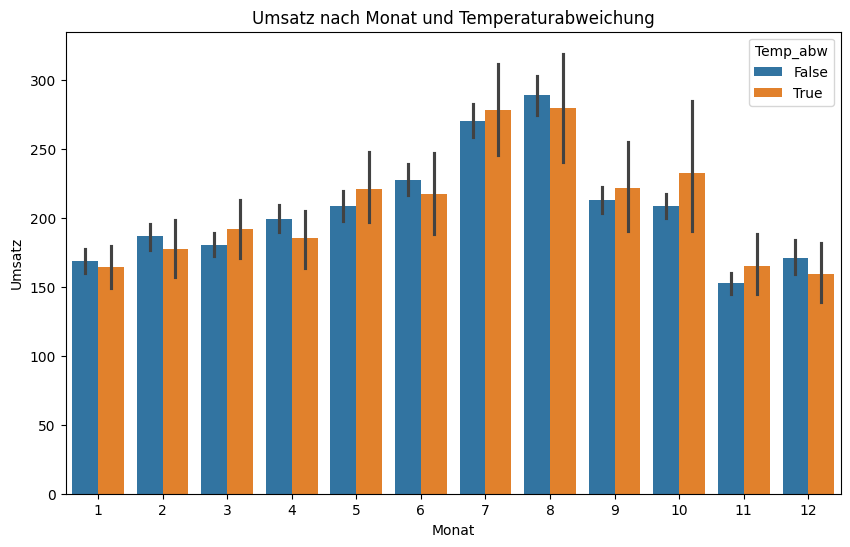

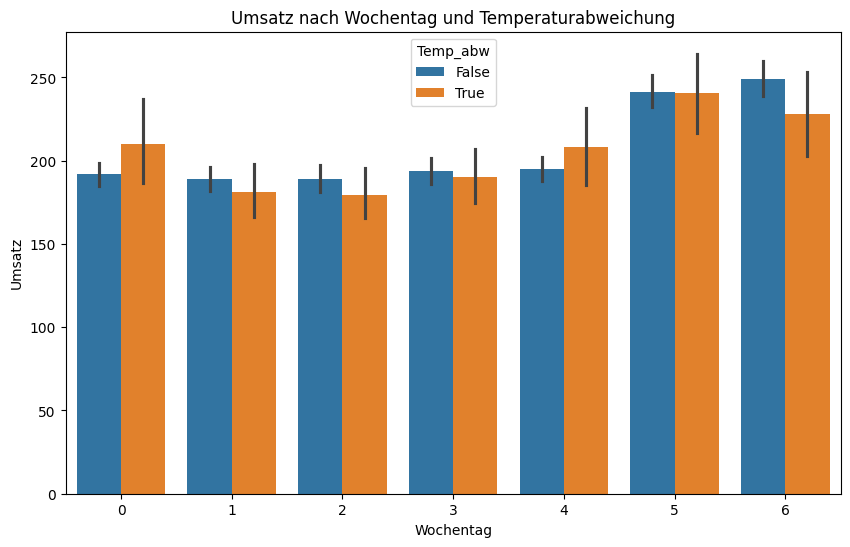

In [20]:
# Pakete laden
import seaborn as sns
# Temp_abw als Balkendiagramm mit Konfidenzintervall anzeigen nach Monat und Umsatz
plt.figure(figsize=(10, 6))
sns.barplot(x='Monat', y='Umsatz', hue='Temp_abw', data=merged_data)
plt.title('Umsatz nach Monat und Temperaturabweichung')
plt.show()

# Temp_abw als Balkendiagramm mit Konfidenzintervall anzeigen nach Wochentag und Umsatz
plt.figure(figsize=(10, 6))
sns.barplot(x='Wochentag', y='Umsatz', hue='Temp_abw', data=merged_data)
plt.title('Umsatz nach Wochentag und Temperaturabweichung')
plt.show()


## Bewölkung und Windgeschwindigkeit in kategoriale Variable transformieren

In [21]:
# Variable erstellen, die die Bewölkung in kategoriale Variable umwandelt
merged_data['Bewoelkung_kat'] = pd.cut(merged_data['Bewoelkung'], bins=[0, 3, 6, 9], labels=[0, 1, 2], include_lowest=True)

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())

# Nur minimal größerer Zusammenhang zwischen Bewölkung und Umsatz (siehe Korrelation)

# Windgeschwindigkeit in kategoriale Variable (minimum 3 und mximum 35) umwandeln
merged_data['Windgeschwindigkeit_kat'] = pd.cut(merged_data['Windgeschwindigkeit'], bins=[0, 5, 10, 15, 20, 25, 30, 35], labels=[0, 1, 2, 3, 4, 5, 6])

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())
print(merged_data.isna().sum())

       Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  \
0                 14.0        58.0          NaN         1        True   
1                 12.0         NaN          NaN         0       False   
2                 18.0        63.0          NaN         0       False   
3                 19.0        80.0          NaN         0       False   
4                 23.0        80.0          NaN         0       False   

   Wochentag  Monat  Temp_abw Bewoelkung_kat  
0          6      1      True              2  
1          0      1     False              2  
2          1      1     False              2  
3     

## Zeitvariablen und Lagged Variables hinzufügen

In [22]:
# Neue Zeitvariablen hinzufügen
merged_data['Kalenderwoche'] = pd.to_datetime(merged_data['Datum']).dt.isocalendar().week
merged_data['Jahreszeit'] = pd.to_datetime(merged_data['Datum']).dt.month % 12 // 3 + 1

# Lagged Variables hinzufügen (Umsatz einen Tag und eine Woche zuvor)
merged_data['Umsatz_lag1'] = merged_data['Umsatz'].shift(1)
merged_data['Umsatz_lag7'] = merged_data['Umsatz'].shift(7)

# Feiertag in den nächsten drei Tagen
merged_data['Feiertag_in_3_tagen'] = merged_data['Feiertag'].rolling(window=4, min_periods=1).max().shift(-3)

# Durchschnittlicher Umsatz der letzten drei Tage vor einem Feiertag
# Initialisieren der neuen Spalte mit NaN
merged_data['durchschnittlicher_Umsatz_vor_Feiertag'] = np.nan

# Berechnung des durchschnittlichen Umsatzes der letzten drei Tage vor einem Feiertag
for i in range(len(merged_data)):
    if merged_data.loc[i, 'Feiertag_in_3_tagen'] == 1:
        merged_data.loc[i, 'durchschnittlicher_Umsatz_vor_Feiertag'] = merged_data.loc[i-3:i-1, 'Umsatz'].mean()

# Anzeigen von random Zeilen des DataFrame mit den neuen Spalten
print(merged_data.sample(5))
print(merged_data)

# Zeilen anzeigen mit Feiertag_in_3_tagen
print(merged_data[merged_data['Feiertag_in_3_tagen'] == 1])

# Anzeigen welche Daten als Feiertage markiert sind
print(merged_data[merged_data['Feiertag'] == 1])


           Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
3477  2015-01-29          2.0  276.548941         7.0       1.500   
8611  2017-11-15          5.0  206.279762         7.0       9.375   
8694  2017-11-29          4.0   77.532784         7.0       4.225   
10231 2019-06-09          NaN         NaN         5.0      18.650   
8123  2017-08-11          4.0  192.905986         7.0      16.375   

       Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  \
3477                  12.0        75.0          NaN         0       False   
8611                   7.0        61.0          NaN         0       False   
8694                   6.0        61.0          NaN         0       False   
10231                 10.0         NaN          NaN         0        True   
8123                   8.0        61.0          NaN         0       False   

       ...  Monat  Temp_abw  Bewoelkung_kat Windgeschwindigkeit_kat  \
3477   ...      1     False               2        

## Wettercode umcodieren in qualitative Zustände

In [27]:
# Funktion zur Umkodierung
def wetter_kategorie(code):
    if code in [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 42, 43]:
        return 'positiv'
    elif code in [0, 2, 31, 34, 44, 45]:
        return 'neutral'
    elif code in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32, 35, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]:
        return 'negativ'
    else:
        return np.nan

# Anwendung der Funktion auf die Wettercode-Spalte
merged_data['Wetterzustand'] = merged_data['Wettercode'].apply(wetter_kategorie)

# Zustände mit 0, 1, 2 kodieren und NaNs beibehalten
zustand_mapping = {'positiv': 0, 'neutral': 1, 'negativ': 2}
merged_data['Wetterzustand'] = merged_data['Wetterzustand'].map(zustand_mapping)

# Ergebnis anzeigen
print(merged_data)

           Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0     2012-01-01          NaN     NaN         8.0      9.8250   
1     2012-01-02          NaN     NaN         7.0      7.4375   
2     2012-01-03          NaN     NaN         8.0      5.5375   
3     2012-01-04          NaN     NaN         4.0      5.6875   
4     2012-01-05          NaN     NaN         6.0      5.3000   
...          ...          ...     ...         ...         ...   
10280 2019-07-28          NaN     NaN         3.0     23.3500   
10281 2019-07-29          NaN     NaN         6.0     25.2500   
10282 2019-07-30          NaN     NaN         7.0     20.7375   
10283 2019-07-31          NaN     NaN         6.0     20.4500   
10284 2019-08-01          NaN     NaN         5.0     21.0625   

       Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  \
0                     14.0        58.0          NaN         1        True   
1                     12.0         NaN          NaN         0    

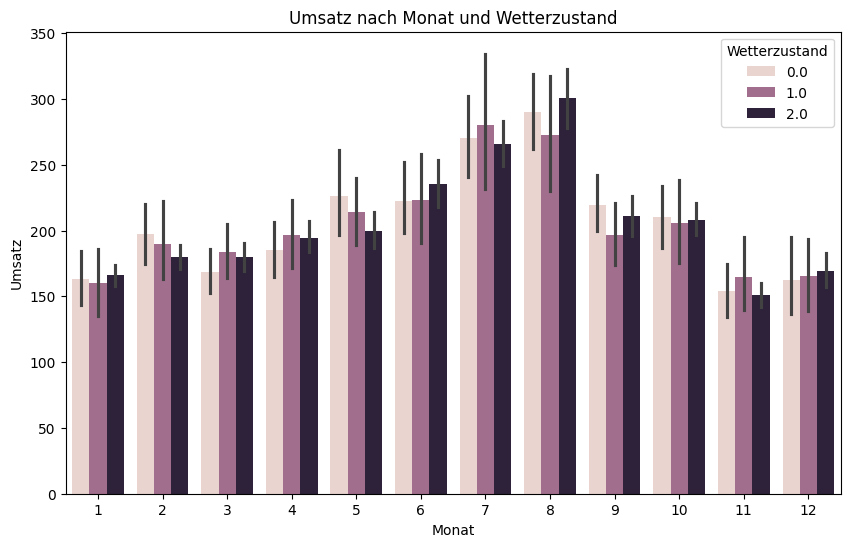

In [28]:
# Wetterzustand als Balkendiagramm mit Konfidenzintervall anzeigen nach Monat und Umsatz
plt.figure(figsize=(10, 6))
sns.barplot(x='Monat', y='Umsatz', hue='Wetterzustand', data=merged_data)
plt.title('Umsatz nach Monat und Wetterzustand')
plt.show()



## Kieler Woche binär kodieren

In [144]:
# Kieler Woche als binäre Variable mit 1 für Kieler Woche und 0 für nicht Kieler Woche
merged_data['Kieler_Woche'] = merged_data['Datum'].between('2012-06-16', '2012-06-24') | \
                              merged_data['Datum'].between('2013-06-22', '2013-06-30') | \
                              merged_data['Datum'].between('2014-06-21', '2014-06-29') | \
                              merged_data['Datum'].between('2015-06-20', '2015-06-28') | \
                              merged_data['Datum'].between('2016-06-18', '2016-06-26') | \
                              merged_data['Datum'].between('2017-06-17', '2017-06-25') | \
                              merged_data['Datum'].between('2018-06-16', '2018-06-24') | \
                              merged_data['Datum'].between('2019-06-22', '2019-06-30')
# KielerWoche entfernen
merged_data = merged_data.drop('KielerWoche', axis=1)

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())

       Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  Feiertag  Wochenende  Wochentag  ...  \
0                 14.0        58.0         1        True          6  ...   
1                 12.0         NaN         0       False          0  ...   
2                 18.0        63.0         0       False          1  ...   
3                 19.0        80.0         0       False          2  ...   
4                 23.0        80.0         0       False          3  ...   

   Bewoelkung_kat  Windgeschwindigkeit_kat Kalenderwoche Jahreszeit  \
0               2                        2            52          1   
1               2                 

## Umgang mit fehlenden Werten Überblick

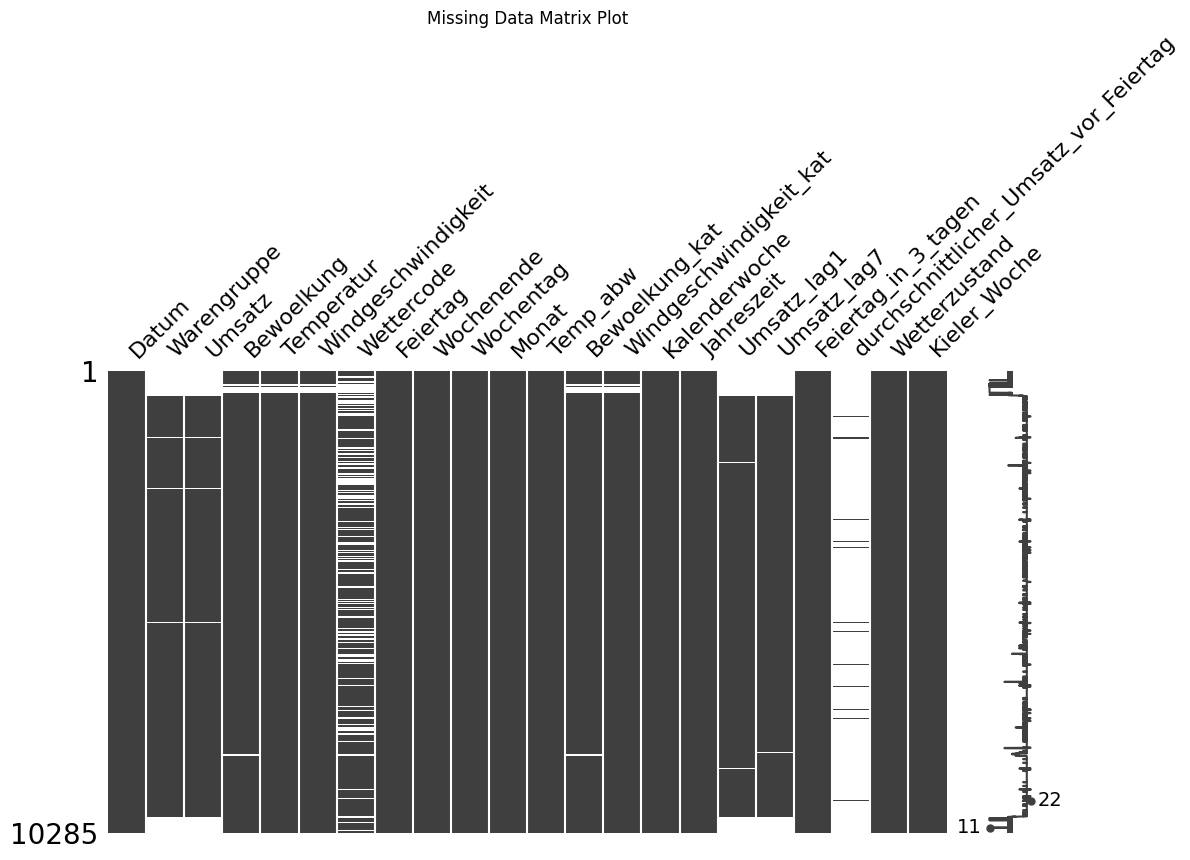

In [145]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from fancyimpute import IterativeImputer, KNN

# Matrix plot of missing data
msno.matrix(merged_data, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()

## Imputation 

In [146]:
# Create a mask for the imputed values
mask = merged_data['Wettercode'].isna()  # mask for missing values in 'Ozone'

In [147]:
# Entferne die Datumsfelder
data_no_dates = merged_data.drop(columns=['Datum', "Wetterzustand"])

# KNN-Imputation durchführen
imputer_knn = KNN()
imputed_data_KNN = pd.DataFrame(imputer_knn.fit_transform(data_no_dates), columns=data_no_dates.columns)

# Füge die Datumsfelder wieder hinzu
imputed_data_KNN['Datum'] = merged_data['Datum'].values

Imputing row 1/10285 with 5 missing, elapsed time: 17.691
Imputing row 101/10285 with 5 missing, elapsed time: 17.707
Imputing row 201/10285 with 5 missing, elapsed time: 17.724
Imputing row 301/10285 with 11 missing, elapsed time: 17.742
Imputing row 401/10285 with 11 missing, elapsed time: 17.775
Imputing row 501/10285 with 5 missing, elapsed time: 17.806
Imputing row 601/10285 with 1 missing, elapsed time: 17.817
Imputing row 701/10285 with 2 missing, elapsed time: 17.823
Imputing row 801/10285 with 2 missing, elapsed time: 17.828
Imputing row 901/10285 with 1 missing, elapsed time: 17.833
Imputing row 1001/10285 with 1 missing, elapsed time: 17.837
Imputing row 1101/10285 with 1 missing, elapsed time: 17.842
Imputing row 1201/10285 with 1 missing, elapsed time: 17.845
Imputing row 1301/10285 with 2 missing, elapsed time: 17.850
Imputing row 1401/10285 with 1 missing, elapsed time: 17.853
Imputing row 1501/10285 with 1 missing, elapsed time: 17.857
Imputing row 1601/10285 with 1 mis

In [148]:
# Iterative Robust Model Imputation (IRMI)
imputer_irmi = IterativeImputer()
imputed_data_irmi = pd.DataFrame(imputer_irmi.fit_transform(data_no_dates), columns=data_no_dates.columns)

# Füge die Datumsfelder wieder hinzu
imputed_data_irmi['Datum'] = merged_data['Datum'].values

/home/codespace/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Beispiel: Vorhersage mit RandomForest
train_data = data_no_dates.dropna(subset=['Wettercode'])
test_data = data_no_dates[data_no_dates['Wettercode'].isna()]

clf = RandomForestClassifier()
clf.fit(train_data.drop(columns=['Wettercode']), train_data['Wettercode'])

# Hier wird data_no_dates mit den predicitions aufgefüllt (siehe Plot unten)
predictions = clf.predict(test_data.drop(columns=['Wettercode']))
data_no_dates.loc[data_no_dates['Wettercode'].isna(), 'Wettercode'] = predictions

In [150]:
# Define a function for scatter plots that highlights imputed values
def plot_scatter_with_imputation(data, x, y, mask, title='Scatter Plot', xlabel='X-axis', ylabel='Y-axis'):
    plt.figure(figsize=(10, 6))
    # Plot non-imputed points
    sns.scatterplot(x=data.loc[~mask, x], y=data.loc[~mask, y], color='blue', label='Original')
    # Plot imputed points
    sns.scatterplot(x=data.loc[mask, x], y=data.loc[mask, y], color='red', label='Imputed')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

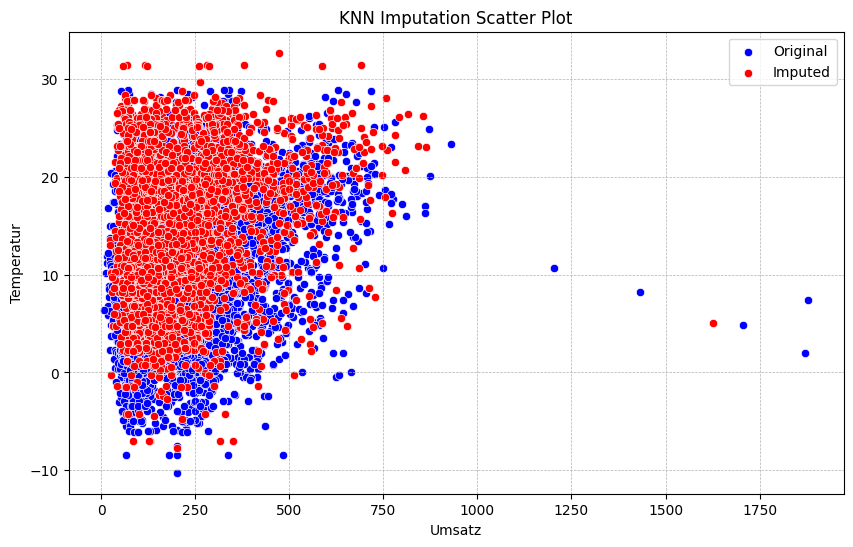

In [151]:
# Plotting results for KNN imputation
plot_scatter_with_imputation(imputed_data_KNN, 'Umsatz', 'Temperatur', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Temperatur')

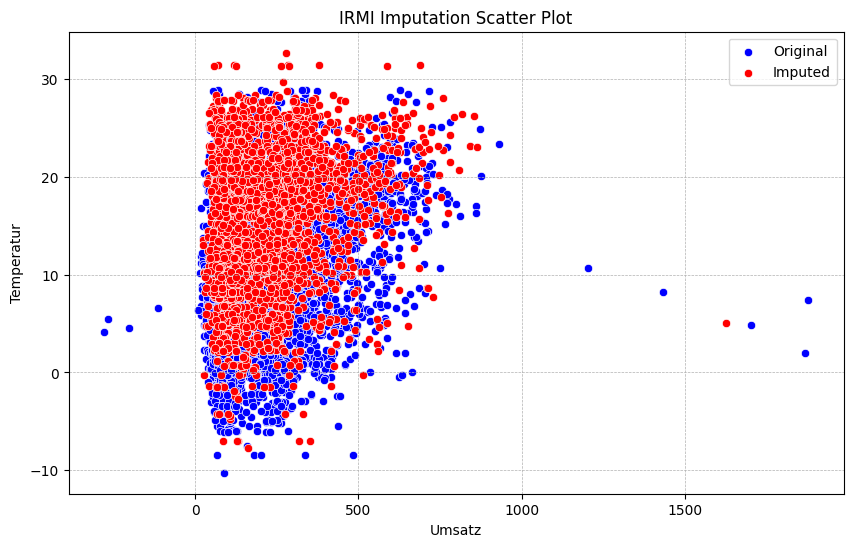

In [152]:
# Plotting results for IRMI imputation
plot_scatter_with_imputation(imputed_data_irmi, 'Umsatz', 'Temperatur', mask, 'IRMI Imputation Scatter Plot', 'Umsatz', 'Temperatur')

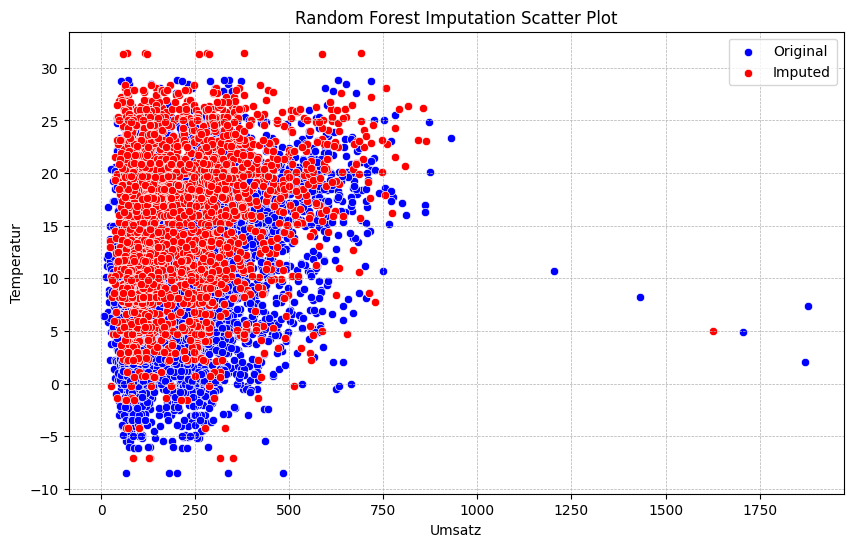

In [153]:
plot_scatter_with_imputation(data_no_dates, 'Umsatz', 'Temperatur', mask, 'Random Forest Imputation Scatter Plot', 'Umsatz', 'Temperatur')

In [154]:
print("Correlation in original data:", merged_data["Umsatz"].corr(merged_data['Temperatur'], method='pearson'))
print("Correlation after KNN imputation:", imputed_data_KNN["Umsatz"].corr(imputed_data_KNN['Temperatur']))
print("Correlation after IRMI:", imputed_data_irmi["Umsatz"].corr(imputed_data_irmi['Temperatur']))
print("Correlation after RF imputation:", data_no_dates["Umsatz"].corr(data_no_dates['Temperatur']))

Correlation in original data: 0.22293543679239128
Correlation after KNN imputation: 0.22958694654133388
Correlation after IRMI: 0.2307626854535202
Correlation after RF imputation: 0.22293543679239128


## Korrelationen

In [155]:
# Korrelationen aller Variablen nur mit dem Umsatz für Wettercode imputierte Daten (RF-Imputation) ohne Datum
print(data_no_dates.corr())

# Korrelationsmatrix für nicht imputierte Daten mit Datum
print(merged_data.corr())


                                        Warengruppe    Umsatz  Bewoelkung  \
Warengruppe                                1.000000 -0.062589    0.023795   
Umsatz                                    -0.062589  1.000000   -0.089916   
Bewoelkung                                 0.023795 -0.089916    1.000000   
Temperatur                                -0.047015  0.222935   -0.383888   
Windgeschwindigkeit                       -0.009078  0.014705    0.042813   
Wettercode                                 0.016270 -0.042915    0.612950   
Feiertag                                  -0.006163  0.043574   -0.031793   
Wochenende                                 0.000457  0.163097   -0.006312   
Wochentag                                  0.000560  0.136199   -0.005812   
Monat                                      0.080817  0.013889    0.032380   
Temp_abw                                  -0.000134 -0.007693   -0.099163   
Bewoelkung_kat                             0.023757 -0.095877    0.931465   

## Datensätze speichern

In [156]:
# Datensätze speichern
merged_data.to_csv('0_DataPreparation/merged_data.csv', index=False)
imputed_data_KNN.to_csv('0_DataPreparation/imputed_data_KNN.csv', index=False)
imputed_data_irmi.to_csv('0_DataPreparation/imputed_data_irmi.csv', index=False)
data_no_dates.to_csv('0_DataPreparation/imputed_data_RF.csv', index=False)

# Anzeigen wie viele NaNs es gibt
print(merged_data.isnull().sum())
print(imputed_data_KNN.isnull().sum())
print(imputed_data_irmi.isnull().sum())
print(data_no_dates.isnull().sum())



Datum                                         0
Warengruppe                                 951
Umsatz                                      951
Bewoelkung                                  237
Temperatur                                  182
Windgeschwindigkeit                         182
Wettercode                                 2704
Feiertag                                      0
Wochenende                                    0
Wochentag                                     0
Monat                                         0
Temp_abw                                      0
Bewoelkung_kat                              237
Windgeschwindigkeit_kat                     182
Kalenderwoche                                 0
Jahreszeit                                    0
Umsatz_lag1                                 951
Umsatz_lag7                                 951
Feiertag_in_3_tagen                           3
durchschnittlicher_Umsatz_vor_Feiertag    10036
Wetterzustand                           